# BERTopic implementation

In earlier notebooks, I implemented **Non-negative Matrix Factorization (NMF)** for topic modelling.  
In this notebook, I extend that work by implementing **BERTopic**, a transformer based topic modelling appraoch, and conduct a limited sensitivity analysi to assess its suitability relative to the NMF baseline. 

## Purpose of this notebook 

The aim is to test whether reasonable, theoretically motivated adjustments to BERTopic materially improve topic coherence, interpretability, or stability for policy agenda mapping.
Results are used to justify model choice rather than to identify a “best” BERTopic configuration.

## NMF vs BERTopic

**NMF** is a linear, bag-of-words topic model that identifies topics by decomposing a TF-IDF matrix based on word co-occurrence patterns.  
**BERTopic**, in contrast, uses transformer-based embeddings to cluster documents by **semantic meaning**, producing topics that are typically more **context-aware and coherent**.

## Why BERTopic?

### ✅ Pros
- **Semantic understanding**: Uses transformer embeddings, allowing topics to capture meaning and context rather than just word overlap.
- **More coherent topics**: Particularly effective for short texts and noisy, real-world data (e.g. news articles, policy documents, scraped web content).
- **Flexible and modular**: Embedding models, clustering algorithms, and vectorizers can be swapped or tuned.
- **Dynamic topics**: Supports topic evolution over time, making it suitable for longitudinal analyses.
- **Interpretable outputs**: Provides representative documents and topic keywords to aid interpretation.

### ⚠️ Cons
- **Computationally expensive**: Significantly slower and more memory-intensive than NMF or LDA.
- **More moving parts**: The pipeline (embeddings, UMAP, HDBSCAN) increases complexity and makes debugging and tuning harder.
- **Less stable**: Topics can vary across runs unless parameters and random seeds are carefully fixed.
- **Risk of over-clustering**: May produce many small or overly specific topics if not well tuned.
- **Methodological transparency**: The deep-learning and clustering components can be harder to justify in academic or policy-focused contexts.

## Bottom Line

BERTopic is well suited to **meaningful, modern text analysis** where semantic coherence matters, but it trades off **simplicity, speed, and transparency** compared to more traditional approaches like NMF.

# Imports and load data 

In [33]:
#Imports
import pandas as pd
import numpy as np
import unicodedata
import re
import spacy

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

In [4]:
# load data
df = pd.read_csv("/workspaces/AM1_topic_modelling/data/full_retro/full_retro.csv")

# Cleaning Scraped Articles 
##### The order of text cleaning really matters. Regex-based removal of junk must happen before aggressive normalisation, because punctuation and formatting changes can transform noise into clean-looking tokens that no longer match removal patterns and therefore surface as junk topics.


In [7]:
def clean_scraped_article(text):
    if not isinstance(text, str):
        return ""
    
    # ======== STAGE 1: STRUCTURAL FIXES (before removal) ========
    # Do these FIRST so removals work on clean structure
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r"(\w+)-\s*\n\s*(\w+)", r"\1\2", text)  # fix hyphenation
    text = re.sub(r"\n+", " ", text)  # collapse newlines
    
    # ======== STAGE 2: REMOVE BLOCKS (largest units first) ========
    # Remove entire sections before word-level cleaning
    block_patterns = [
        r"accept all cookies.*?cookies policy",
        r"subscribe now.*?(?:access|continue reading)",
        r"you must be logged in.*?continue reading",
        r"sign in to continue.*?(?:subscribe|register)",
        r"start your free trial.*?(?:subscribe|access)",
        r"subscribe for full access.*?(?:here|now)",
        r"crown copyright.*?(?:all rights reserved|\d{4})",
        r"this site uses cookies.*?(?:more information|accept|privacy)",
        r"cookie preference.*?(?:settings|accept)",
        r"privacy policy.*?(?:here|terms)",
        r"accessibility statement.*?(?:here|contact)",
    ]
    for pat in block_patterns:
        text = re.sub(pat, " ", text, flags=re.IGNORECASE | re.DOTALL)
    
    # ======== STAGE 3: REMOVE SPECIFIC PHRASES ========
    # Do this before individual words to avoid creating new combinations
    phrase_patterns = [
        # Navigation
        r"skip to (?:main )?content",
        r"related articles?",
        r"more on this story",
        r"share this article",
        
        # Social media
        r"share on (?:twitter|facebook|linkedin|instagram)",
        r"follow us on",
        r"tweet this",
        
        # Metadata
        r"updated \d{1,2} \w+ \d{4}",
        r"published \d{1,2} \w+ \d{4}",
        r"by [A-Z][a-z]+ [A-Z][a-z]+",  # author bylines
        
        # Government/publication artefacts
        r"available under.*?licen[cs]e",
        r"thank you for your feedback",
        r"find out more",
        r"assistive technology",
        r"accessible format",
    ]
    for pat in phrase_patterns:
        text = re.sub(pat, " ", text, flags=re.IGNORECASE)
    
    # ======== STAGE 4: REMOVE SINGLE WORDS ========
    # Targeted removal of noise terms
    noise_words = {
        # Web structure
        "advertisement", "menu", "home", "navigation", "sidebar",
        
        # PDF artefacts
        "pdf", "obj", "endobj", "xref", "stream", "endstream",
        "mediabox", "cropbox", "trimbox", "bleedbox",
        
        # Social/media
        "instagram", "flickr", "youtube", "twitter", "facebook", 
        "linkedin", "newsletter", "tweet",
        
        # Cookie/privacy
        "cookie", "cooky", "privacy",
        
        # Gov.uk boilerplate
        "copyright", "licence", "license", "crown", "asset",
        
        # Publication metadata
        "summary", "publication", "email", "download", "document",
        "page", "section", "index", "content", "format", "type",
        
        # Units
        "kb", "mb", "isbn",
        
        # Actions
        "share", "print", "visit", "update", "view", "file",
        
        # Misc
        "topic", "blog", "news", "consultation", "feedback",
        "experience", "site", "thank", "ernment"  # cropped 'government'
    }
    pattern = r"\b(?:" + "|".join(noise_words) + r")\b"
    text = re.sub(pattern, " ", text, flags=re.IGNORECASE)
    
    # ======== STAGE 5: HTML/ENTITIES ========
    text = re.sub(r"<.*?>", " ", text)  # HTML tags
    text = re.sub(r"&[a-z]+;", " ", text)  # HTML entities
    
    # ======== STAGE 6: CLEANUP (do this LAST) ========
    text = re.sub(r"[•●▪◆■]", " ", text)  # bullets
    text = re.sub(r"\b(\w+)\s+\1\b", r"\1", text)  # deduplicate adjacent words
    text = re.sub(r"\s+", " ", text).strip()  # final whitespace collapse
    
    return text


# Apply cleaning
print("\nCleaning articles...")
df["text_clean"] = df["text"].apply(clean_scraped_article)
print("Cleaning complete!")


Cleaning articles...
Cleaning complete!


# Prepare data for BERTopic

In [8]:
docs = df["text_clean"].tolist()

In [9]:
print(f"Number of documents: {len(docs)}")
print(f"Sample document length: {len(docs[0])} characters")

Number of documents: 4331
Sample document length: 4494 characters


# B0. BASELINE BERTopic MODEL


## Configure BERTtopic Components 

In [10]:
# Embedding model 
# - 'all-MiniLM-L6-v2': Fast, good for general use (384 dimensions)
# - 'all-mpnet-base-v2': Better quality, slower (768 dimensions)
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

In [11]:
# UMAP for dimensionality reduction
umap_model = UMAP(
    n_neighbors=15,      # Lower = more local structure, higher = more global
    n_components=5,      # Dimensions to reduce to
    min_dist=0.0,        # How tightly to pack points
    metric='cosine',
    random_state=42
)

In [16]:
# HDBSCAN for clustering
hdbscan_model = HDBSCAN(
    min_cluster_size=10,      # Minimum documents per topic
    min_samples=5,            # Conservative clustering
    metric='euclidean',
    cluster_selection_method='eom', 
    prediction_data=True
)

In [17]:
# Vectorizer for topic representation 
vectorizer_model = CountVectorizer(
    min_df=3,
    max_df=0.85,
    ngram_range=(1, 2),
    stop_words='english'
)

## Initialize and Fit BERTopic Model

In [18]:
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    top_n_words=20,
    nr_topics=20,  # Set to 20 to match your NMF model, or use 'auto' for automatic
    calculate_probabilities=True,
    verbose=True
)

In [20]:
#fit the model 
topics, probs = topic_model.fit_transform(docs)
print(f"✅ Model fitted!")

2026-01-09 12:45:04,873 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [05:21<00:00,  2.37s/it]
2026-01-09 12:50:27,170 - BERTopic - Embedding - Completed ✓
2026-01-09 12:50:27,171 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-09 12:50:32,970 - BERTopic - Dimensionality - Completed ✓
2026-01-09 12:50:32,971 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-09 12:50:34,679 - BERTopic - Cluster - Completed ✓
2026-01-09 12:50:34,680 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2026-01-09 12:50:37,660 - BERTopic - Representation - Completed ✓
2026-01-09 12:50:37,662 - BERTopic - Topic reduction - Reducing number of topics
2026-01-09 12:50:37,672 - BERTopic - Representation - Fine-tuning topics using representation

In [21]:
print(f"Number of topics found: {len(set(topics)) - 1}")  # -1 excludes outlier topic
print(f"Outlier documents (topic -1): {topics.count(-1)}")

✅ Model fitted!
Number of topics found: 19
Outlier documents (topic -1): 962


## Record baseline summary

In [52]:
baseline_summary = {
    "experiment": "B0_baseline",
    "embedding": "MiniLM",
    "min_cluster_size": 10,
    "domain_stopwords": False,
    "n_topics": len(set(topics)) - 1,
    "outliers": topics.count(-1)
}
baseline_summary

{'experiment': 'B0_baseline',
 'embedding': 'MiniLM',
 'min_cluster_size': 10,
 'domain_stopwords': False,
 'n_topics': 19,
 'outliers': 962}

# B1. EMBEDDING MODEL SWAP

In [54]:
embedding_model_mpnet = SentenceTransformer("all-mpnet-base-v2")

topic_model_mpnet = BERTopic(
    embedding_model=embedding_model_mpnet,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    nr_topics=20,
    calculate_probabilities=True,
    verbose=True
)

topics_mpnet, _ = topic_model_mpnet.fit_transform(docs)

2026-01-09 13:44:57,070 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [1:12:34<00:00, 32.02s/it]
2026-01-09 14:57:32,007 - BERTopic - Embedding - Completed ✓
2026-01-09 14:57:32,012 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-09 14:57:37,806 - BERTopic - Dimensionality - Completed ✓
2026-01-09 14:57:37,807 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-09 14:57:39,727 - BERTopic - Cluster - Completed ✓
2026-01-09 14:57:39,728 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2026-01-09 14:57:42,668 - BERTopic - Representation - Completed ✓
2026-01-09 14:57:42,669 - BERTopic - Topic reduction - Reducing number of topics
2026-01-09 14:57:42,696 - BERTopic - Representation - Fine-tuning topics using representation

# Cluster Size Sensitivity 

In [ ]:
hdbscan_large = HDBSCAN(
    min_cluster_size=20,
    min_samples=5,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

topic_model_cluster20 = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_large,
    vectorizer_model=vectorizer_model,
    nr_topics=20,
    calculate_probabilities=True,
    verbose=True
)

topics_cluster20, _ = topic_model_cluster20.fit_transform(docs)

# B3. DOMAIN STOPWORDS (FROM NMF)

In [ ]:
# ======================================================
# CONSOLIDATED DOMAIN STOPWORDS
# Used across NMF and BERTopic for policy text modelling
# ======================================================

from spacy.lang.en.stop_words import STOP_WORDS

DOMAIN_STOPWORDS = set(STOP_WORDS).union({

    # --------------------------------------------------
    # Media / source identifiers
    # --------------------------------------------------
    "schoolsweek",

    # --------------------------------------------------
    # Temporal terms
    # --------------------------------------------------
    "day", "days", "week", "weeks", "month", "months", "year", "years",
    "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday",
    "today", "yesterday", "tomorrow", "daily", "weekly", "monthly", "yearly",
    "term", "terms", "spring", "summer", "autumn", "winter",
    "january", "february", "march", "april", "may", "june", "july", "august",
    "september", "october", "november", "december",

    # --------------------------------------------------
    # Web / social / UI junk
    # --------------------------------------------------
    "share", "print", "visit", "site", "experience", "cookie",
    "banner", "footer", "header", "subscribe", "subscription",
    "accessibility", "archive", "toggle", "skip", "select",

    # --------------------------------------------------
    # Publication / metadata language
    # --------------------------------------------------
    "summary", "publication", "topic", "news", "blog", "thank",
    "article", "report", "statistic", "research", "consultation",
    "datum", "info", "contact", "event", "commission", "foundation",
    "document", "detail", "section", "annex", "appendix",
    "letter", "email", "submission", "item", "version", "draft",

    # --------------------------------------------------
    # Generic / overused policy language
    # --------------------------------------------------
    "use", "work", "information", "time", "job", "thing", "way",
    "government", "policy", "service", "people", "need", "make",
    "number", "cent", "high", "new", "different", "large", "place",
    "individual", "human", "view", "analysis", "change", "support",

    # --------------------------------------------------
    # Organisational / structural terms
    # --------------------------------------------------
    "organisation", "org", "institute", "committee", "department",
    "office", "official", "programme", "scheme", "initiative", "pilot",

    # --------------------------------------------------
    # Procedural / bureaucratic language
    # --------------------------------------------------
    "guidance", "framework", "response", "statement",
    "proposal", "approach", "review", "update",
    "issued", "signed", "recipient", "sender",
    "correspondence", "notification", "circulated",

    # --------------------------------------------------
    # Vague / filler policy discourse
    # --------------------------------------------------
    "summit", "voice", "stakeholder", "partnership",
    "engagement", "dialogue",

    # --------------------------------------------------
    # Lemmatization / parser artefacts
    # --------------------------------------------------
    "cooky", "prev", "fed", "tv", "size", "join",
    "structparent", "annot", "font", "tabs", "rotate", "rr", "page",

    # --------------------------------------------------
    # Statistical / reporting scaffolding
    # --------------------------------------------------
    "percentage", "proportion", "point", "figure",
    "survey", "rate", "level", "score",

    # --------------------------------------------------
    # Newsletter / filler language
    # --------------------------------------------------
    "interesting", "fact", "mover", "shaker",
    "previous", "current", "date",

    # --------------------------------------------------
    # Implementation / rollout language
    # --------------------------------------------------
    "introduce", "implement", "launch", "rollout",

    # --------------------------------------------------
    # Generic evaluative adjectives
    # --------------------------------------------------
    "good", "low"
})

In [ ]:
DOMAIN_STOPWORDS = (
    MEDIA
    | TIME_STOPWORDS
    | CUSTOM_STOPWORDS
    | JUNK_TERMS
)

vectorizer_domain = CountVectorizer(
    min_df=3,
    max_df=0.85,
    ngram_range=(1, 2),
    stop_words=list(DOMAIN_STOPWORDS)
)

topic_model_domain = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_domain,
    nr_topics=20,
    calculate_probabilities=True,
    verbose=True
)

topics_domain, _ = topic_model_domain.fit_transform(docs)

# Add Topic Assignments to DataFrame

In [23]:
df["bertopic_num"] = topics
df["bertopic_prob"] = probs.max(axis=1) if probs is not None else np.nan

In [24]:
# Get topic info
topic_info = topic_model.get_topic_info()
print("\n📊 Topic Info:")
print(topic_info.head(10))


📊 Topic Info:
   Topic  Count                                               Name  \
0     -1    962                   -1_children_pupils_cent_teachers   
1      0   1412                    0_pupils_cent_children_teachers   
2      1    522                   1_ofsted_trust_inspection_trusts   
3      2    295                         2_maths_pupils_grades_cent   
4      3    252            3_academy_academies_school academy_html   
5      4    232                    4_ai_children_teachers_learners   
6      5    120  5_apprenticeship_apprenticeships_apprentices_e...   
7      6    100     6_scholarship_scholarships_scholars_university   
8      7     92                 7_start date_interesting_fact_date   
9      8     74             8_research_justice_nuffield_foundation   

                                      Representation  \
0  [children, pupils, cent, teachers, ofsted, tru...   
1  [pupils, cent, children, teachers, dfe, pay, a...   
2  [ofsted, trust, inspection, trusts, inspect

#  Visualize Topics

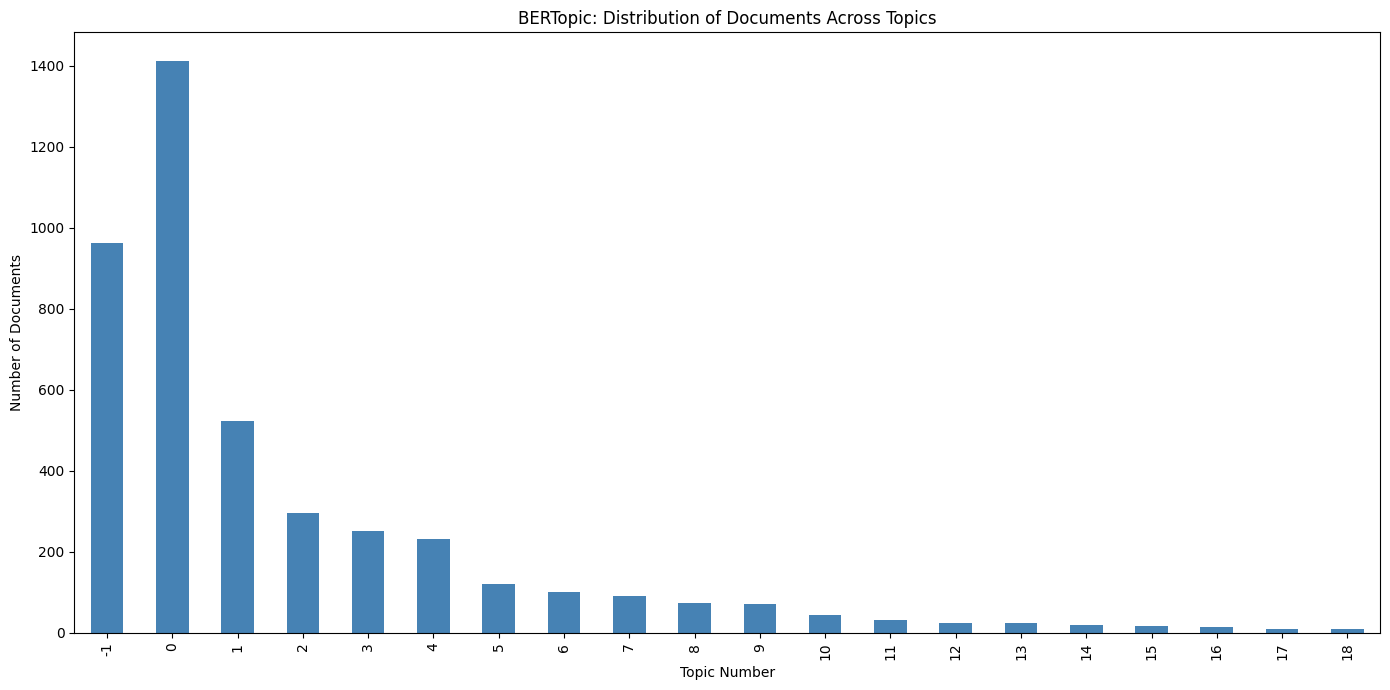

In [25]:
plt.figure(figsize=(14, 7))
topic_counts = df["bertopic_num"].value_counts().sort_index()
topic_counts.plot(kind='bar', color='steelblue')
plt.xlabel('Topic Number')
plt.ylabel('Number of Documents')
plt.title('BERTopic: Distribution of Documents Across Topics')
plt.tight_layout()
plt.show()

#  Extract and Display Topic Keywords

In [26]:
print("\n🔍 Top words per BERTopic:\n")
for topic_id in sorted(topic_info['Topic'].unique()):
    if topic_id == -1:
        continue  # Skip outlier topic
    
    topic_words = topic_model.get_topic(topic_id)
    if topic_words:
        words = [word for word, _ in topic_words[:15]]
        print(f"Topic {topic_id}: {', '.join(words)}")


🔍 Top words per BERTopic:

Topic 0: pupils, cent, children, teachers, dfe, pay, absence, send, parents, pupil, leaders, primary, teacher, secondary, councils
Topic 1: ofsted, trust, inspection, trusts, inspections, inspectors, report, academy, leaders, inspector, children, chief, cent, pupils, oliver
Topic 2: maths, pupils, grades, cent, subjects, results, levels, qualifications, grade, gcse, entries, reading, english, 2019, pandemic
Topic 3: academy, academies, school academy, html, notice, applies england, england documents, sign emails, latest information, applies, education skills, emails, updates sign, updates, local authorities
Topic 4: ai, children, teachers, learners, technology, world, teaching, best, fed, country, leaders, day, climate, tools, community
Topic 5: apprenticeship, apprenticeships, apprentices, employers, sellafield, engineering, degree, space, industry, construction, businesses, growth, sector, careers, career
Topic 6: scholarship, scholarships, scholars, unive

# Interactive Visualizations

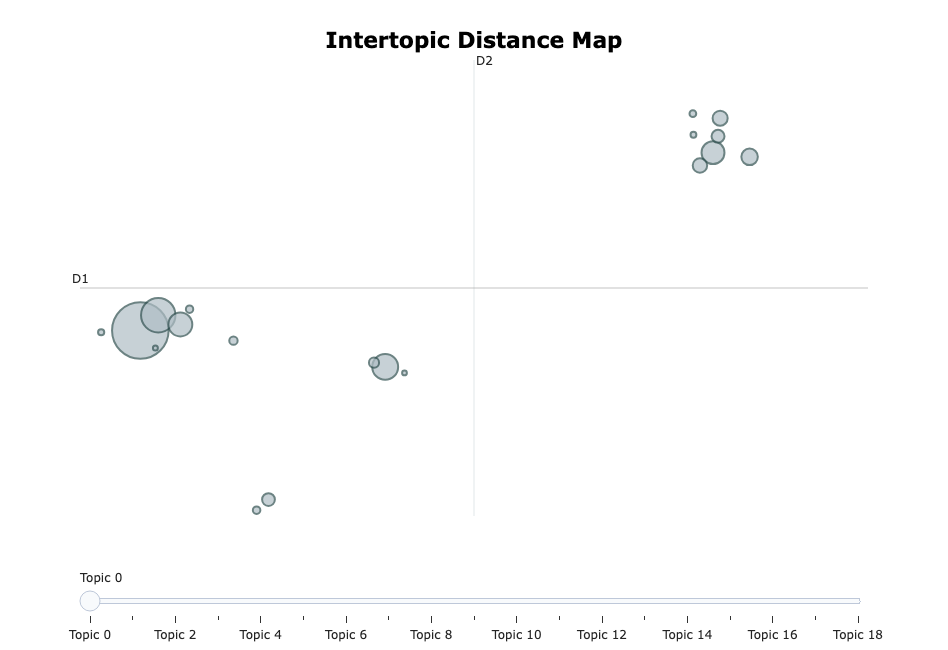

In [34]:
# Visualize topics in 2D space
try:
    fig1 = topic_model.visualize_topics()
    fig1.show()
except Exception as e:
    print(f"Could not create topic visualization: {e}")

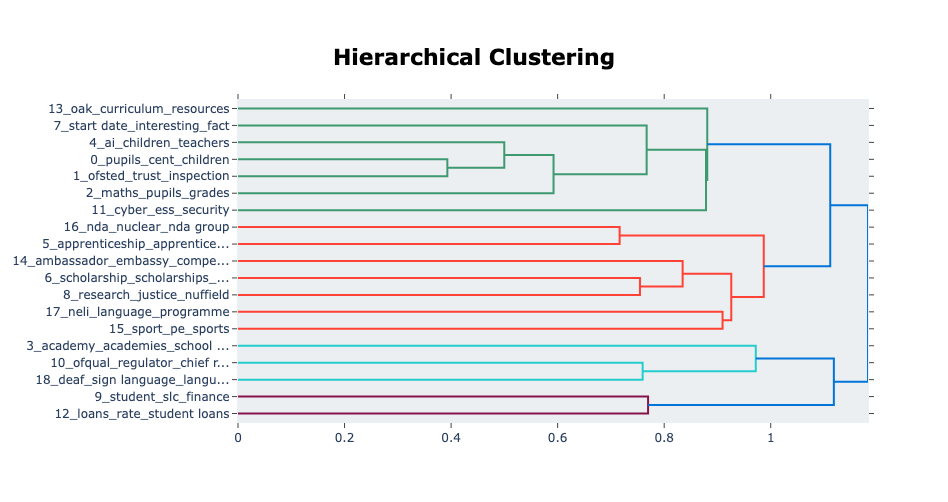

In [35]:
# Visualize topic hierarchy
try:
    fig2 = topic_model.visualize_hierarchy()
    fig2.show()
except Exception as e:
    print(f"Could not create hierarchy visualization: {e}")

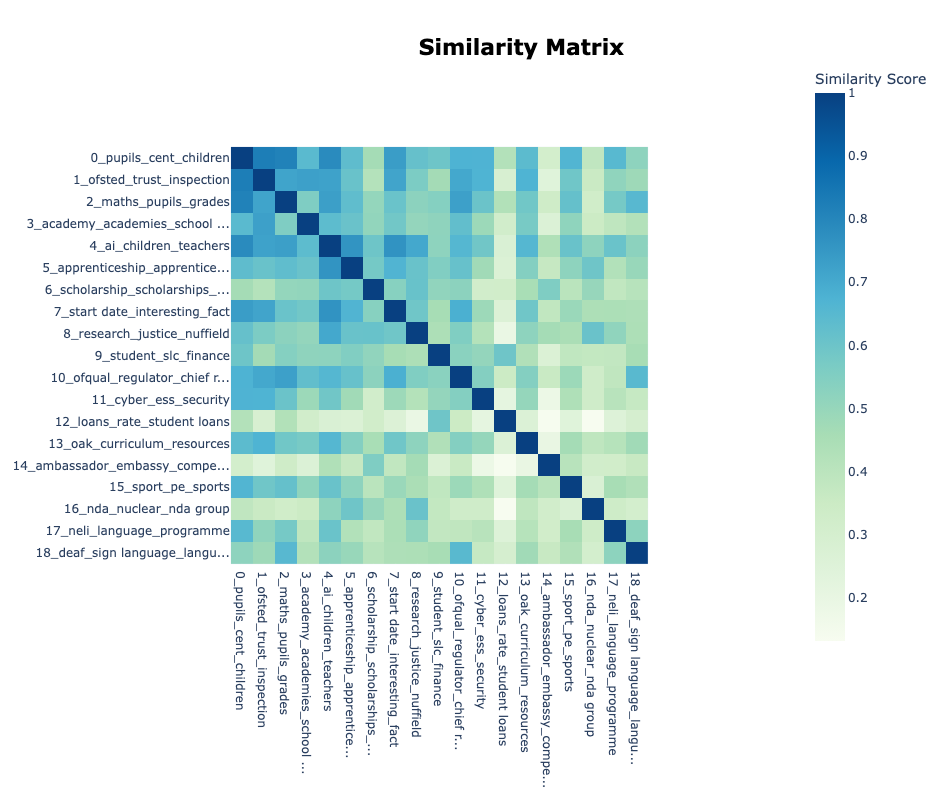

In [36]:
# Visualize topic similarity (heatmap)
try:
    fig3 = topic_model.visualize_heatmap()
    fig3.show()
except Exception as e:
    print(f"Could not create heatmap visualization: {e}")

# Create Tokens for Coherence Evaluation

In [37]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def tokenize_for_coherence(text):
    """Tokenize text for coherence evaluation"""
    if not isinstance(text, str):
        return []
    
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc 
              if token.pos_ in {"NOUN", "PROPN", "ADJ"} 
              and not token.is_stop 
              and token.is_alpha
              and len(token.lemma_) > 2]  # Remove very short tokens
    return tokens

In [38]:
# Tokenize (this may take a few minutes)
df["tokens_coherence"] = df["text_clean"].apply(tokenize_for_coherence)
print(f"Tokenization complete! Sample: {df['tokens_coherence'].iloc[0][:10]}")

Tokenization complete! Sample: ['significant', 'shift', 'shape', 'early', 'education', 'care', 'ecec', 'previous', 'government', 'budget']


# Topic Coherence Evaluation

In [39]:
# Extract topic words for coherence calculation
bertopic_words = []
for topic_id in sorted(set(topics)):
    if topic_id == -1:
        continue
    topic_words = topic_model.get_topic(topic_id)
    if topic_words:
        words = [word for word, _ in topic_words[:10]]
        bertopic_words.append(words)

In [40]:
# Use gensim for coherence
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

In [41]:
# Prepare texts and dictionary
texts_for_coherence = df["tokens_coherence"].tolist()
dictionary_bert = Dictionary(texts_for_coherence)

In [42]:
# Calculate coherence
cm_bert = CoherenceModel(
    topics=bertopic_words,
    texts=texts_for_coherence,
    dictionary=dictionary_bert,
    coherence='c_v'
)
coherence_bert = cm_bert.get_coherence()

In [43]:
print(f"\n✅ BERTopic Coherence Score (C_V): {coherence_bert:.4f}")
print(f"   Higher scores indicate more coherent topics (typically 0.3-0.7)")
print(f"   Your score: {'Good' if coherence_bert > 0.4 else 'Moderate' if coherence_bert > 0.3 else 'Could be improved'}")


✅ BERTopic Coherence Score (C_V): 0.5246
   Higher scores indicate more coherent topics (typically 0.3-0.7)
   Your score: Good


# Topic Mapping and Top Documents

In [44]:
def show_top_docs_bertopic(topic_num, df, n=5):
    """Display top documents for a specific BERTopic"""
    topic_docs = df[df["bertopic_num"] == topic_num].copy()
    topic_docs = topic_docs.sort_values("bertopic_prob", ascending=False).head(n)
    
    print(f"\n🔎 Top {n} documents for BERTopic {topic_num}\n")
    for idx, row in topic_docs.iterrows():
        print(f"--- Document (index {idx}, prob: {row['bertopic_prob']:.3f}) ---")
        print(row["text"][:1000])
        print("\n")

In [45]:
# Example: show top docs for topic 0
show_top_docs_bertopic(0, df)


🔎 Top 5 documents for BERTopic 0

--- Document (index 6, prob: 1.000) ---
“Characteristics, experiences and outcomes of children registered – and not registered, when entitled – for free school meals” is an output of a wider project funded by the Nuffield Foundation: “ What has FSM measured and what are the implications?”
It is published alongside the project’s main public report, “R egistration for Free School Meals (FSM): issues and implications for research, policymaking, practice and access”. This research investigates two main questions:
The analysis utilises newly available linked data from the Millennium Cohort Study (MCS) , which tracked a large national sample of children from the turn of the century into adulthood. The MCS data includes detailed welfare benefits and income information across school years (ages five, seven, 11, and 14), which is linked with yearly FSM registration data from the National Pupil Database (NPD) and the Households Below Average Income dataset .
Th

# Save BERTopic Results

In [47]:
# Save topic info
topic_info.to_csv("/workspaces/AM1_topic_modelling/data/Interrim/bertopic_info.csv", index=False)

In [49]:
# Save model for later use


In [ ]:
# Export top documents per topic
 

# BERTopic Sensitivity Analysis (Exploratory)